
# Assignment 2: Text Classification
Marko Praček, Vid Koncilja <div>
januar 2025

### Imports:

In [66]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np


# Task 1 - Data preparation and exploration


### Load the data and extract some basic information
- Are there missing values?
- what is the distribution of the class variable?
- How long are the texts?



MISSING VALUES
 text     0
label    0
dtype: int64

CLASS DISTRIBUTION
 label
1    1703
0    1443
3     671
4     584
2     401
5     198
Name: count, dtype: int64


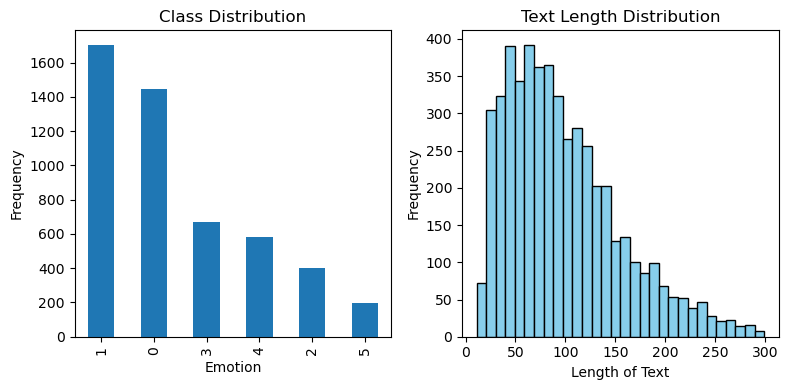

In [67]:
data = []
with open('dataset.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)

#check if any data is missing
missing_values = df.isnull().sum()
print("\nMISSING VALUES\n",missing_values)



class_distribution = df['label'].value_counts()

print("\nCLASS DISTRIBUTION\n",class_distribution)

df['text_length'] = df['text'].apply(len)
text_length_stats = df['text_length'].describe()
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
class_distribution.plot(kind='bar', title='Class Distribution', xlabel='Emotion', ylabel='Frequency')
plt.subplot(1, 2, 2)
plt.hist(df['text_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Split the data into train, test, validation sets

# Task 2 - Basic machine learning

## Decision Tree Classifier

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('classifier', DecisionTreeClassifier(random_state=42))  # Placeholder classifier
])

# Define the parameter grid for different models
param_grid = [
    # Decision Tree
    {
        'classifier': [DecisionTreeClassifier(random_state=42)],
        'classifier__max_depth': [5, 10, 20, None],
        'classifier__min_samples_split': [2, 5, 10]
    },
    # Random Forest
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [5, 10, 20, None],
        'classifier__min_samples_split': [2, 5, 10]
    },
    # Gradient Boosting (Boosting)
    {
        'classifier': [GradientBoostingClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 10]
    }
]

# Perform grid search to find the best model and hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(train_data['text'], y_train)

# Evaluate on validation data
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(val_data['text'])
print("Best Model Parameters:", grid_search.best_params_)
print("Validation Performance:")
print(classification_report(y_val, y_val_pred))

# Evaluate on test data
y_test_pred = best_model.predict(test_data['text'])
print("Test Performance:")
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 75 candidates, totalling 375 fits


KeyboardInterrupt: 

Validation Accuracy: 0.79
Test Accuracy: 0.81


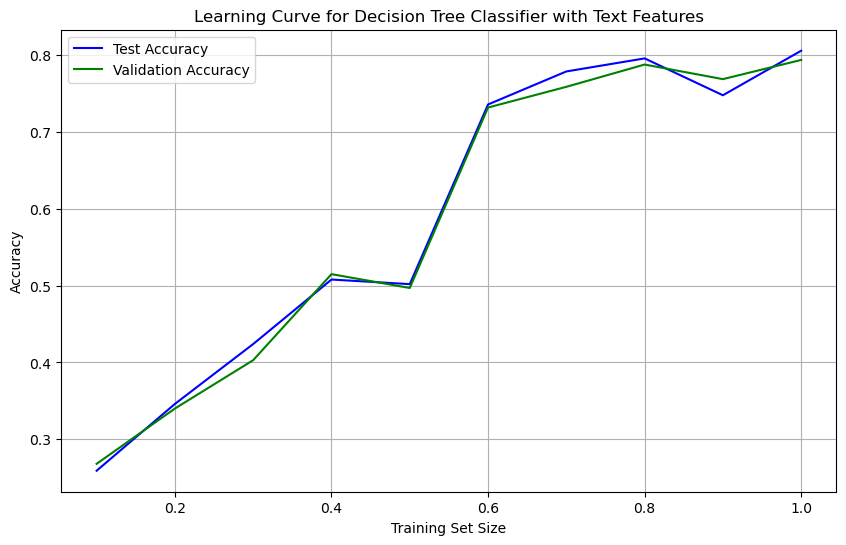

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


df['text'] = df['text'].fillna("") 
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_data, val_data = train_test_split(train_data, test_size=0.25, stratify=train_data['label'], random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

X_train = train_data['text']
y_train = train_data['label']

X_val = val_data['text']
y_val = val_data['label']

X_test = test_data['text']
y_test = test_data['label']

pipeline.fit(X_train, y_train)

val_accuracy = accuracy_score(y_val, pipeline.predict(X_val))
test_accuracy = accuracy_score(y_test, pipeline.predict(X_test))
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

train_sizes = np.linspace(0.1, 1.0, 10)
test_accuracies = []
val_accuracies = []

for train_size in train_sizes:
    current_train_data = train_data.sample(frac=train_size, random_state=42)
    X_current_train = current_train_data['text']
    y_current_train = current_train_data['label']
    
    pipeline.fit(X_current_train, y_current_train)
    
    test_acc = accuracy_score(y_test, pipeline.predict(X_test))
    test_accuracies.append(test_acc)
    
    val_acc = accuracy_score(y_val, pipeline.predict(X_val))
    val_accuracies.append(val_acc)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, test_accuracies, label="Test Accuracy", color="blue")
plt.plot(train_sizes, val_accuracies, label="Validation Accuracy", color="green")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Decision Tree Classifier with Text Features")
plt.legend()
plt.grid()
plt.show()



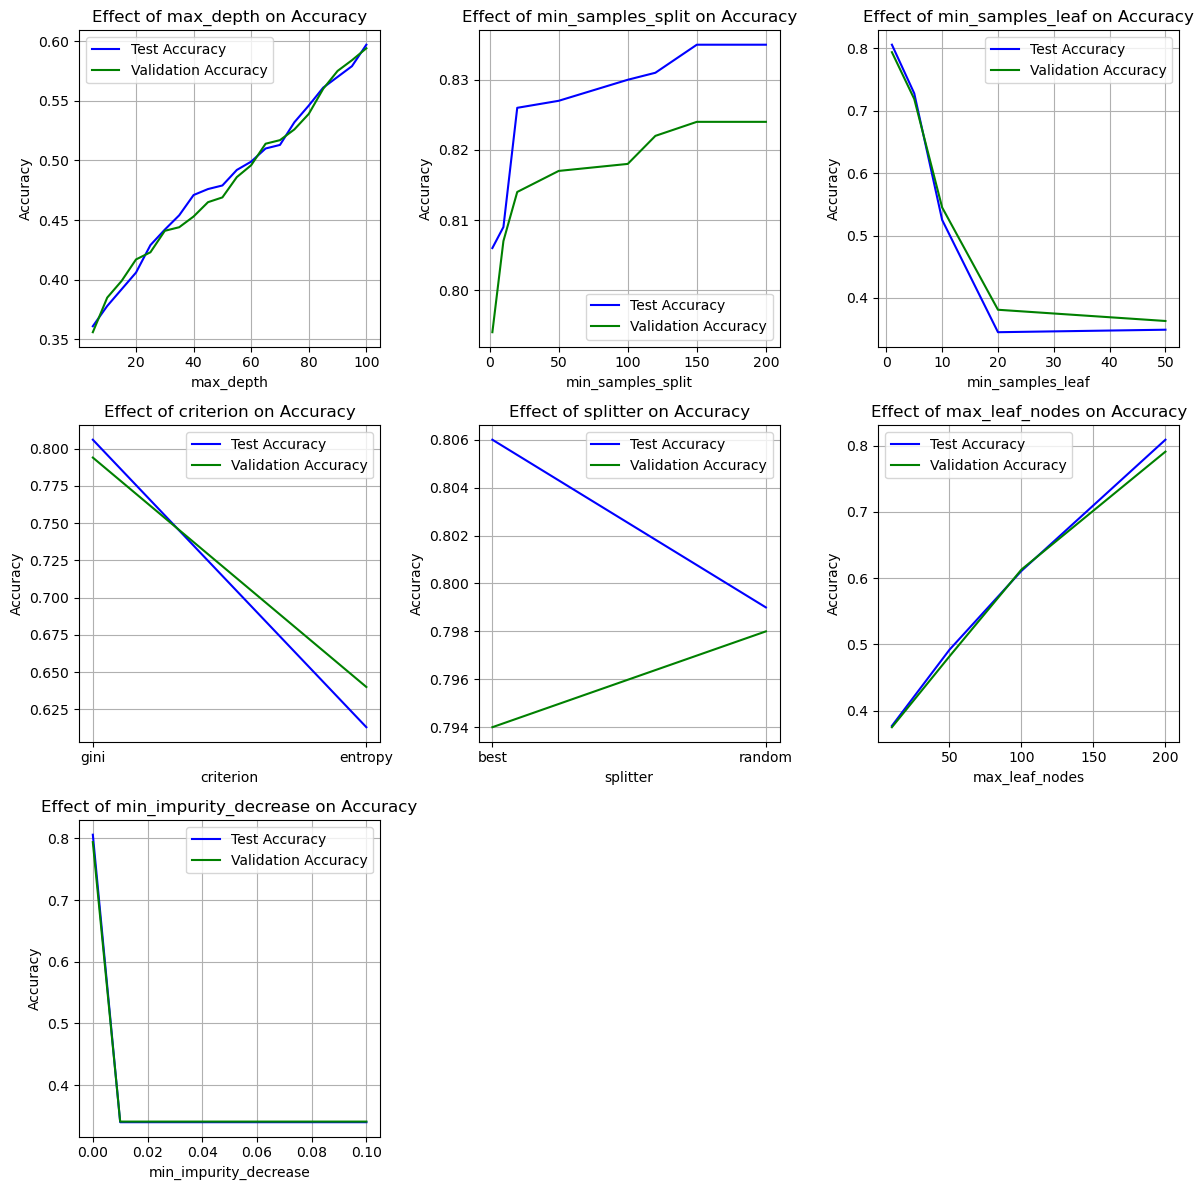

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Function to plot learning curve for each hyperparameter
def plot_learning_curve_for_param(param_name, param_values, X_train, y_train, X_val, y_val):
    test_accuracies = []
    val_accuracies = []
    
    for param_value in param_values:
        pipeline_copy = clone(pipeline)
        
        pipeline_copy.set_params(**{f'classifier__{param_name}': param_value})
        
        pipeline_copy.fit(X_train, y_train)
        
        test_acc = accuracy_score(y_test, pipeline_copy.predict(X_test))
        val_acc = accuracy_score(y_val, pipeline_copy.predict(X_val))

        test_accuracies.append(test_acc)
        val_accuracies.append(val_acc)

    plt.plot(param_values, test_accuracies, label="Test Accuracy", color="blue")
    plt.plot(param_values, val_accuracies, label="Validation Accuracy", color="green")
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.title(f"Effect of {param_name} on Accuracy")
    plt.legend()
    plt.grid(True)

# Generate plots for each hyperparameter

# 1. max_depth
max_depth_values = np.arange(5, 300, 10)
plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plot_learning_curve_for_param('max_depth', max_depth_values, X_train, y_train, X_val, y_val)

# 2. min_samples_split
min_samples_split_values = np.arange(0,350,50)
plt.subplot(3, 3, 2)
plot_learning_curve_for_param('min_samples_split', min_samples_split_values, X_train, y_train, X_val, y_val)

# 3. min_samples_leaf
min_samples_leaf_values = [1, 5, 10, 20, 50]
plt.subplot(3, 3, 3)
plot_learning_curve_for_param('min_samples_leaf', min_samples_leaf_values, X_train, y_train, X_val, y_val)

# 4. criterion
criterion_values = ['gini', 'entropy']
plt.subplot(3, 3, 4)
plot_learning_curve_for_param('criterion', criterion_values, X_train, y_train, X_val, y_val)


# 6. splitter
splitter_values = ['best', 'random']
plt.subplot(3, 3, 5)
plot_learning_curve_for_param('splitter', splitter_values, X_train, y_train, X_val, y_val)

# 7. max_leaf_nodes
max_leaf_nodes_values = [10, 50, 100, 200,250,300,350,400]
plt.subplot(3, 3, 6)
plot_learning_curve_for_param('max_leaf_nodes', max_leaf_nodes_values, X_train, y_train, X_val, y_val)

# 8. min_impurity_decrease
min_impurity_decrease_values = [0.0, 0.01, 0.05, 0.1]
plt.subplot(3, 3, 7)
plot_learning_curve_for_param('min_impurity_decrease', min_impurity_decrease_values, X_train, y_train, X_val, y_val)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Define the parameter grid
param_grid = {
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 10, 20],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt', 'log2', None],
}

# Perform GridSearchCV with return_train_score=True
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy', return_train_score=True)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# Evaluate on the test set using the best model
best_model = grid_search.best_estimator_
test_accuracy = accuracy_score(y_test, best_model.predict(X_test))
print(f"Test Accuracy with Best Model: {test_accuracy:.2f}")



Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 20}
Best Score: 0.7070000000000001
Test Accuracy with Best Model: 0.83


## RANDOM FOREST CLASSIFIER

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer


# Define the pipeline with TfidfVectorizer and RandomForestClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier(random_state=42))
])



pipeline.fit(X_train, y_train)

# Function to plot learning curve for each hyperparameter
n_estimators_values = np.arange(10,1000,100)
plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plot_learning_curve_for_param('n_estimators', n_estimators_values, X_train, y_train, X_val, y_val)

# 2. max_depth
max_depth_values = np.arange(10, 300, 10)
plt.subplot(3, 3, 2)
plot_learning_curve_for_param('max_depth', max_depth_values, X_train, y_train, X_val, y_val)

# 3. min_samples_split
min_samples_split_values = np.arange(10,200,10)
plt.subplot(3, 3, 3)
plot_learning_curve_for_param('min_samples_split', min_samples_split_values, X_train, y_train, X_val, y_val)

# 4. min_samples_leaf
min_samples_leaf_values = [1, 5, 10, 50]
plt.subplot(3, 3, 4)
plot_learning_curve_for_param('min_samples_leaf', min_samples_leaf_values, X_train, y_train, X_val, y_val)

# 5. criterion
criterion_values = ['gini', 'entropy']
plt.subplot(3, 3, 5)
plot_learning_curve_for_param('criterion', criterion_values, X_train, y_train, X_val, y_val)


# 7. bootstrap
bootstrap_values = [True, False]
plt.subplot(3, 3, 6)
plot_learning_curve_for_param('bootstrap', bootstrap_values, X_train, y_train, X_val, y_val)

# 8. max_leaf_nodes
max_leaf_nodes_values = np.arrange(10,300,50)
plt.subplot(3, 3, 7)
plot_learning_curve_for_param('max_leaf_nodes', max_leaf_nodes_values, X_train, y_train, X_val, y_val)

# 9. min_impurity_decrease
min_impurity_decrease_values = [0.0, 0.01, 0.05, 0.1]
plt.subplot(3, 3, 8)
plot_learning_curve_for_param('min_impurity_decrease', min_impurity_decrease_values, X_train, y_train, X_val, y_val)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200,450,500,600,700],  
    'classifier__max_depth': [5, 10, 15, None],  
    'classifier__min_samples_split': [2, 10, 20],  
    'classifier__min_samples_leaf': [1, 5, 10], 
    'classifier__criterion': ['gini'], 
}

# Perform GridSearchCV with return_train_score=True
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy', return_train_score=True)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# Evaluate on the test set using the best model
best_model = grid_search.best_estimator_
test_accuracy = accuracy_score(y_test, best_model.predict(X_test))
print(f"Test Accuracy with Best Model: {test_accuracy:.2f}")

In [48]:
# Make decision tree classifier
dt_model_DTC = DecisionTreeClassifier(random_state=42)
dt_model_DTC.fit(X_train, y_train)
y_pred = dt_model_DTC.predict(X_val)


Decision Tree Validation Accuracy: 0.847
[[260   8   3   7   8   3]
 [ 14 286  20   7   9   4]
 [  3  12  64   0   1   0]
 [  6   5   0 119   3   1]
 [  8  12   2   1  85   9]
 [  1   2   0   1   3  33]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       289
           1       0.88      0.84      0.86       340
           2       0.72      0.80      0.76        80
           3       0.88      0.89      0.88       134
           4       0.78      0.73      0.75       117
           5       0.66      0.82      0.73        40

    accuracy                           0.85      1000
   macro avg       0.80      0.83      0.81      1000
weighted avg       0.85      0.85      0.85      1000



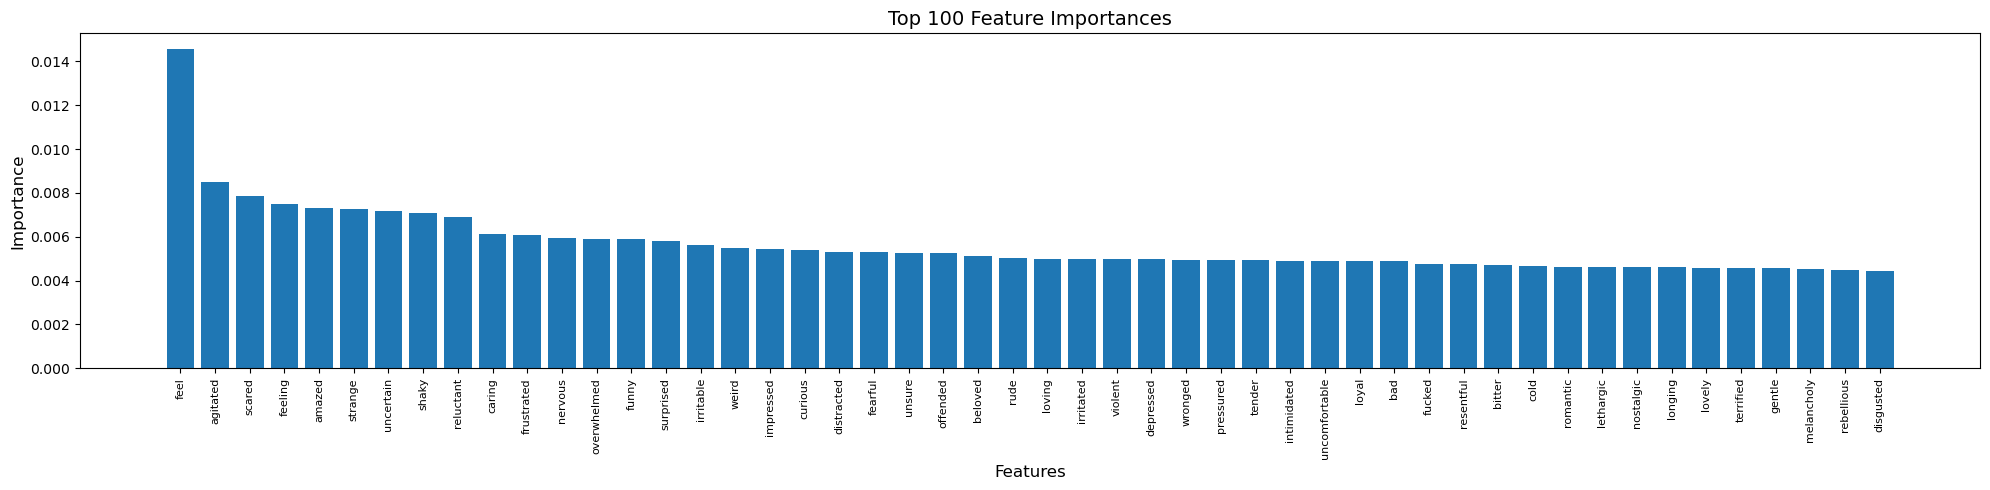

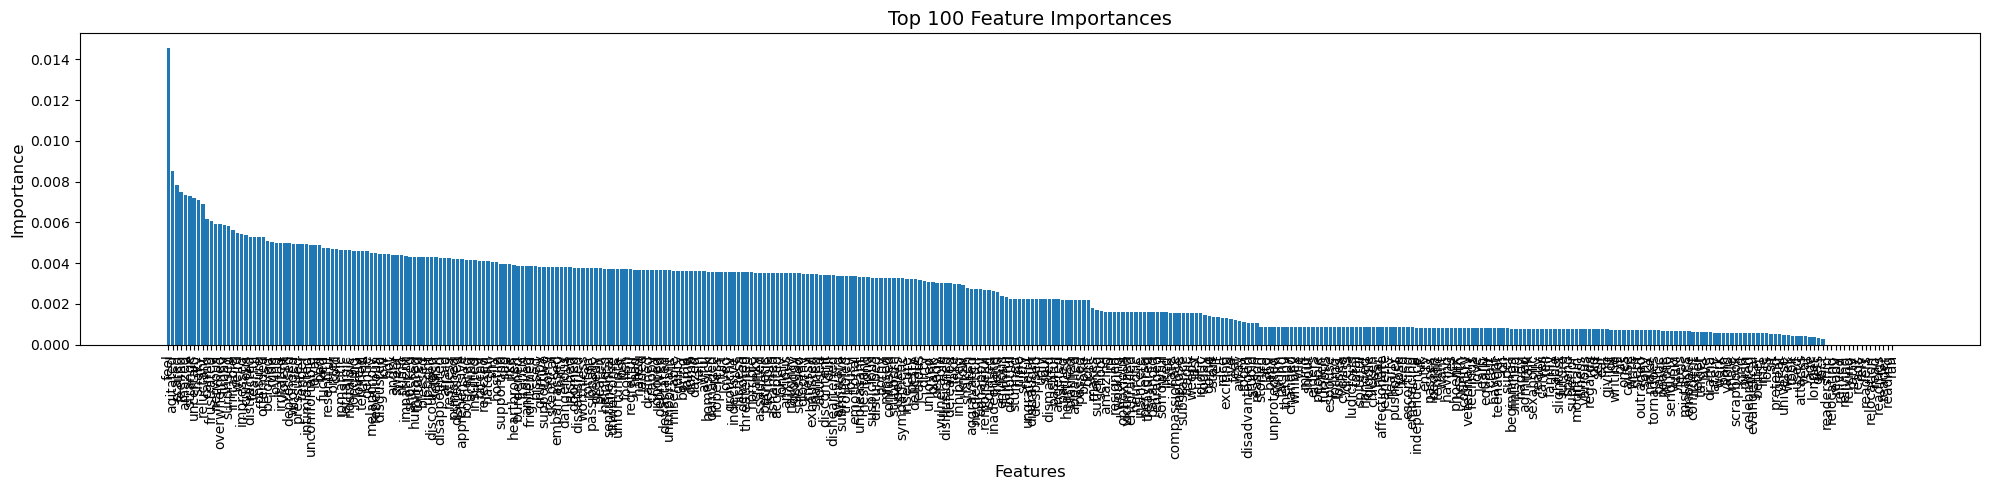

In [14]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
print("Decision Tree Validation Accuracy:", accuracy_score(y_test, dt_predictions))
print(confusion_matrix(y_test, dt_predictions))
print(classification_report(y_test, dt_predictions))
dt_model.feature_importances_
# features = pd.DataFrame(dt_model.feature_importances_, index=vectorizer.get_feature_names_out(), columns=['Importance'])

# features.head(50)


feature_importances = pd.DataFrame({
    'Feature': vectorizer.get_feature_names_out(),
    'Importance': dt_model.feature_importances_
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances_50 = feature_importances.head(50)

plt.figure(figsize=(20, 5))
plt.bar(feature_importances_50['Feature'], feature_importances_50['Importance'])
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Top 100 Feature Importances', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

top_100_features = feature_importances.head(400)

plt.figure(figsize=(20, 5))
plt.bar(top_100_features['Feature'], top_100_features['Importance'])
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Top 100 Feature Importances', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()


# 1 joy    1703 ---------> love = 12, fear = 12
# 0 sad    1443
# 3 anger     671
# 4 fear     584
# 2 love     401 ----------> joy = 20, 
# 5 surprise     198 ----------> fear = 9
#

In [15]:
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)
best_dt_model = grid_search.best_estimator_

val_predictions = best_dt_model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)

test_predictions = best_dt_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)

print("Best Parameters:", grid_search.best_params_)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, test_predictions))
print("\nClassification Report (Test Data):\n", classification_report(y_test, test_predictions))


Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

In [8]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("Random Forest Validation Accuracy:", accuracy_score(y_test, rf_predictions))
print(confusion_matrix(y_test, rf_predictions))

Random Forest Validation Accuracy: 0.82
[[232  39   2   5   8   3]
 [ 12 304  11   4   5   4]
 [  3  20  56   0   1   0]
 [  5  12   0 113   4   0]
 [  5  21   1   1  79  10]
 [  0   3   0   0   1  36]]


In [26]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_val)
print("Gradient Boosting Validation Accuracy:", accuracy_score(y_val, gb_predictions))

Gradient Boosting Validation Accuracy: 0.804


In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)

nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_confusion_matrix = confusion_matrix(y_test, nb_predictions)
nb_classification_report = classification_report(y_test, nb_predictions)

print("Naive Bayes Validation Accuracy:", nb_accuracy)
print("Confusion Matrix:\n", nb_confusion_matrix)
print("Classification Report:\n", nb_classification_report)

# Naive Bayes assumes that features are conditionally independent given the class label. 
# This assumption rarely holds true in real-world NLP tasks, as words in a sentence are often dependent on each other.
# For example, in the text "I am so happy and excited!", the words "happy" and "excited" are semantically related, 
# which Naive Bayes cannot model effectively.



Naive Bayes Validation Accuracy: 0.597
Confusion Matrix:
 [[236  52   0   1   0   0]
 [ 13 327   0   0   0   0]
 [ 19  61   0   0   0   0]
 [ 45  67   0  22   0   0]
 [ 36  68   0   1  12   0]
 [  6  34   0   0   0   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.82      0.73       289
           1       0.54      0.96      0.69       340
           2       0.00      0.00      0.00        80
           3       0.92      0.16      0.28       134
           4       1.00      0.10      0.19       117
           5       0.00      0.00      0.00        40

    accuracy                           0.60      1000
   macro avg       0.52      0.34      0.31      1000
weighted avg       0.61      0.60      0.51      1000



c:\Users\marko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [36]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)


svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_confusion_matrix = confusion_matrix(y_test, svm_predictions)
svm_classification_report = classification_report(y_test, svm_predictions)

print("SVM Validation Accuracy:", svm_accuracy)
print("Confusion Matrix:\n", svm_confusion_matrix)
print("Classification Report:\n", svm_classification_report)

SVM Validation Accuracy: 0.827
Confusion Matrix:
 [[251  21   4   5   7   1]
 [ 12 310   8   5   4   1]
 [  4  24  50   1   1   0]
 [ 16   9   0 106   3   0]
 [ 17  10   1   1  83   5]
 [  1   6   0   0   6  27]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       289
           1       0.82      0.91      0.86       340
           2       0.79      0.62      0.70        80
           3       0.90      0.79      0.84       134
           4       0.80      0.71      0.75       117
           5       0.79      0.68      0.73        40

    accuracy                           0.83      1000
   macro avg       0.82      0.76      0.79      1000
weighted avg       0.83      0.83      0.82      1000



In [39]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)
logistic_predictions = logistic_model.predict(X_test)

logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_confusion_matrix = confusion_matrix(y_test, logistic_predictions)
logistic_classification_report = classification_report(y_test, logistic_predictions)

print("Logistic Regression Validation Accuracy:", logistic_accuracy)
print("Confusion Matrix:\n", logistic_confusion_matrix)
print("Classification Report:\n", logistic_classification_report)

Logistic Regression Validation Accuracy: 0.748
Confusion Matrix:
 [[251  29   2   2   5   0]
 [ 12 326   1   1   0   0]
 [ 14  46  19   0   1   0]
 [ 21  26   0  85   2   0]
 [ 23  29   1   1  60   3]
 [  4  27   0   0   2   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82       289
           1       0.67      0.96      0.79       340
           2       0.83      0.24      0.37        80
           3       0.96      0.63      0.76       134
           4       0.86      0.51      0.64       117
           5       0.70      0.17      0.28        40

    accuracy                           0.75      1000
   macro avg       0.80      0.56      0.61      1000
weighted avg       0.78      0.75      0.72      1000



<h1>Naloga 3</h1>